## Imports

In [2]:
import kagglehub
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import random
import torchvision.models as models

In [ ]:
# path = kagglehub.dataset_download("sidharkal/sports-image-classification")

# print("Path to dataset files:", path)

In [6]:
data_dir = "../data"
images_dir = "../data/dataset/"
train_dir = images_dir + "train/"

badminton_train_dir = train_dir + "Badminton/"
tennis_train_dir = train_dir + "Tennis/"
cricket_train_dir = train_dir + "Cricket/"
soccer_train_dir = train_dir + "Soccer/"
swimming_train_dir = train_dir + "Swimming/"
karate_train_dir = train_dir + "Karate/"
wrestling_train_dir = train_dir + "Wrestling/"

test_dir = images_dir + "test/"

badminton_test_dir = test_dir + "Badminton/"
tennis_test_dir = test_dir + "Tennis/"
cricket_test_dir = test_dir + "Cricket/"
soccer_test_dir = test_dir + "Soccer/"
swimming_test_dir = test_dir + "Swimming/"
karate_test_dir = test_dir + "Karate/"
wrestling_test_dir = test_dir + "Wrestling/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
torch.manual_seed(42)

In [8]:
#shutil.copytree(path, data_dir, dirs_exist_ok=True)

## Organizing Data structure

In [9]:
# checking the train.csv , test.csv
train_df = pd.read_csv(images_dir +"/train.csv")
test_df = pd.read_csv(images_dir +"/test.csv")

In [10]:
test_df

,image_ID
0,f5e13966e7.jpg
1,6674191b4e.jpg
2,91b5f8b7a9.jpg
3,393119b6d6.jpg
4,1ce5f81578.jpg
...,...
2051,7be6c552a7.jpg
2052,4c9427f2a5.jpg
2053,0f429ae0d4.jpg
2054,a6557bedd9.jpg


In [11]:
train_df

,image_ID,label
0,7c225f7b61.jpg,Badminton
1,b31.jpg,Badminton
2,acb146546c.jpg,Badminton
3,0e62f4d8f2.jpg,Badminton
4,cfd2c28c74.jpg,Cricket
...,...,...
8222,903d2fffb3.jpg,Cricket
8223,b5f174c688.jpg,Badminton
8224,2433770a67.jpg,Tennis
8225,6403964166.jpg,Tennis


In [12]:
train_df.set_index("image_ID", inplace=True), test_df.set_index("image_ID", inplace=True)

(None, None)

### Moving data to be per label

In [13]:
labels = train_df["label"].unique()

for label in labels:
    os.makedirs(train_dir + label, exist_ok=True)
    os.makedirs(test_dir + label, exist_ok=True)

In [14]:
labels

array(['Badminton', 'Cricket', 'Tennis', 'Swimming', 'Soccer',
       'Wrestling', 'Karate'], dtype=object)

In [15]:
train_df.loc['7c225f7b61.jpg']['label']

'Badminton'

In [16]:
print(train_dir)

../data/dataset/train/


In [17]:
for i in range(len(train_df)):
    image_id = train_df.index[i]
    label = train_df['label'][i]
    old_path = train_dir + image_id
    new_path = train_dir + label + "/" + image_id
    if os.path.exists(old_path):
        shutil.move(old_path, new_path)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_16004\728234997.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = train_df['label'][i]


### Labeling Test data as it was unlabeled

In [18]:
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

classes = ['Badminton', 'Cricket', 'Tennis', 'Swimming', 'Soccer', 'Wrestling', 'Karate']

def classify_with_clip(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(text=classes, images=image, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image 
    probs = logits_per_image.softmax(dim=1)
    pred = probs.argmax()
    return classes[pred]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [19]:
for i in tqdm(range(len(test_df))):
    image_id = test_df.index[i]
    image_path = test_dir + image_id
    if not os.path.exists(image_path):
        continue
    label = classify_with_clip(image_path)
    test_df.at[image_id, 'label'] = label
    new_path = test_dir + label + "/" + image_id
    if os.path.exists(image_path):
        shutil.move(image_path, new_path)


100%|██████████| 2056/2056 [00:00<00:00, 64468.90it/s]


## Statistics from the data

### Checking distribution of classes

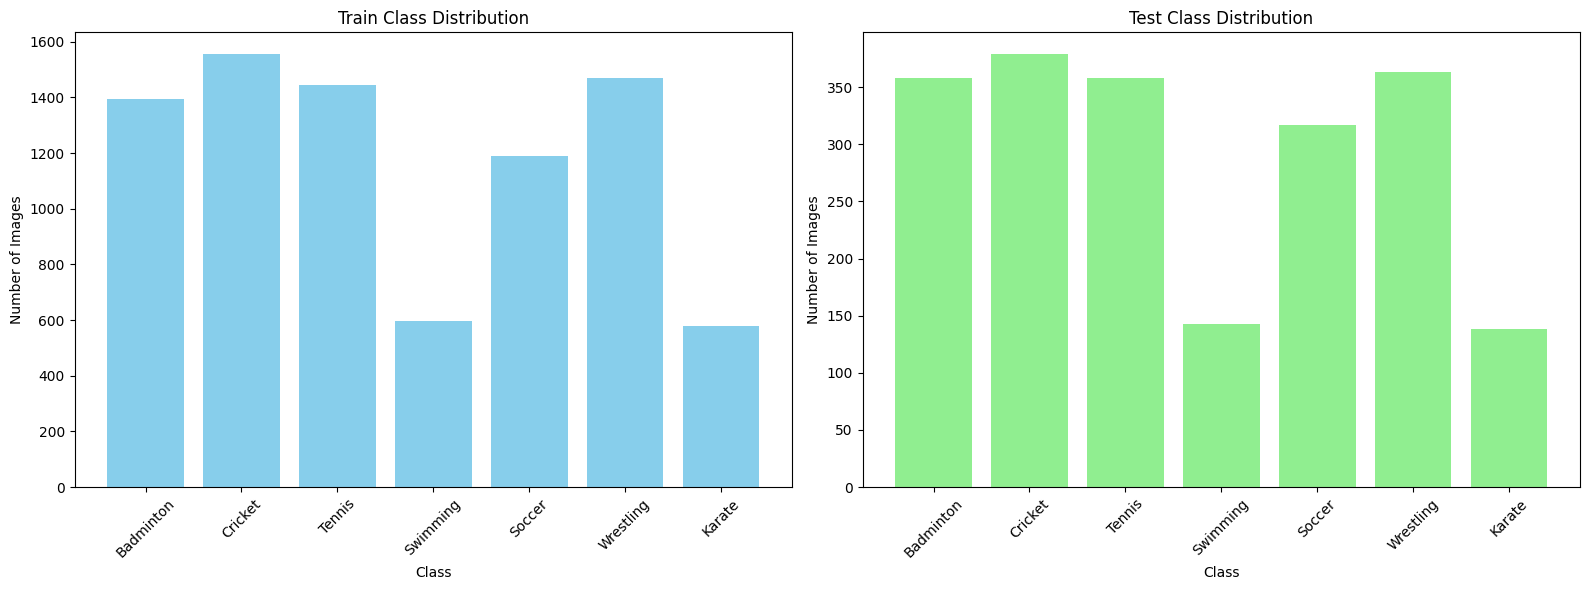

In [20]:

classes = ['Badminton', 'Cricket', 'Tennis', 'Swimming', 'Soccer', 'Wrestling', 'Karate']

train_dirs = [train_dir + cls + "/" for cls in classes]
test_dirs = [test_dir + cls + "/" for cls in classes]

train_counts = [len(os.listdir(d)) if os.path.exists(d) else 0 for d in train_dirs]
test_counts = [len(os.listdir(d)) if os.path.exists(d) else 0 for d in test_dirs]

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].bar(classes, train_counts, color='skyblue')
axs[0].set_title('Train Class Distribution')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Number of Images')
axs[0].tick_params(axis='x', rotation=45)

axs[1].bar(classes, test_counts, color='lightgreen')
axs[1].set_title('Test Class Distribution')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Number of Images')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### Per class statistics

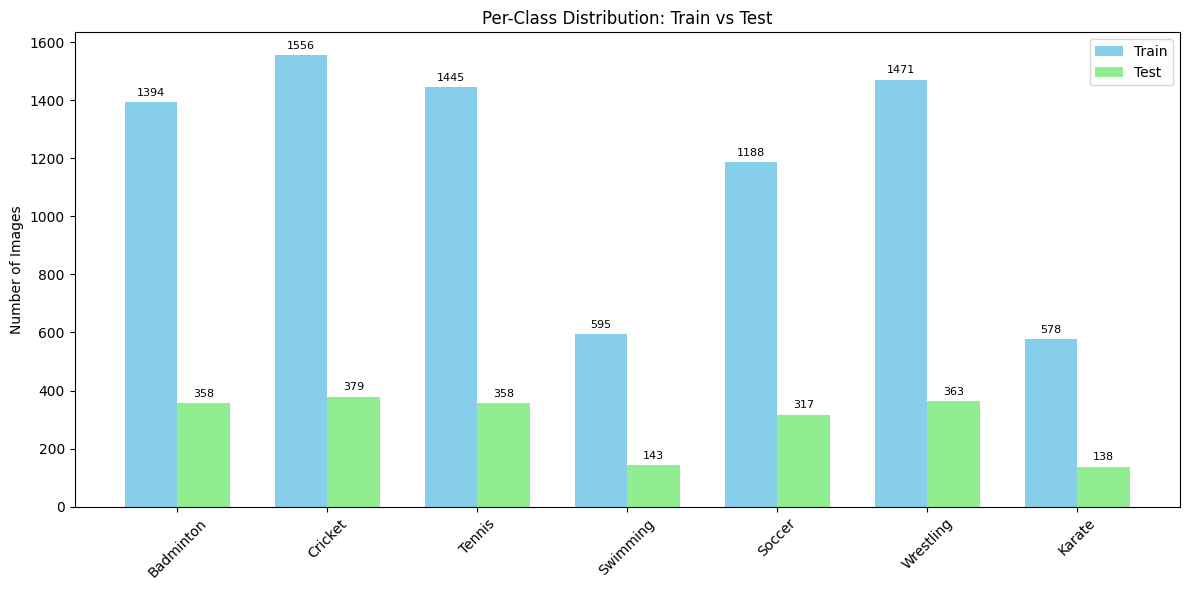

In [21]:
x = np.arange(len(classes))  
width = 0.35  

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, train_counts, width, label='Train', color='skyblue')
rects2 = ax.bar(x + width/2, test_counts, width, label='Test', color='lightgreen')

ax.set_ylabel('Number of Images')
ax.set_title('Per-Class Distribution: Train vs Test')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45)
ax.legend()

def annotate_bars(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

annotate_bars(rects1)
annotate_bars(rects2)

plt.tight_layout()
plt.show()

### Pixel Value Distribution

100%|██████████| 7/7 [00:00<00:00, 77.05it/s]


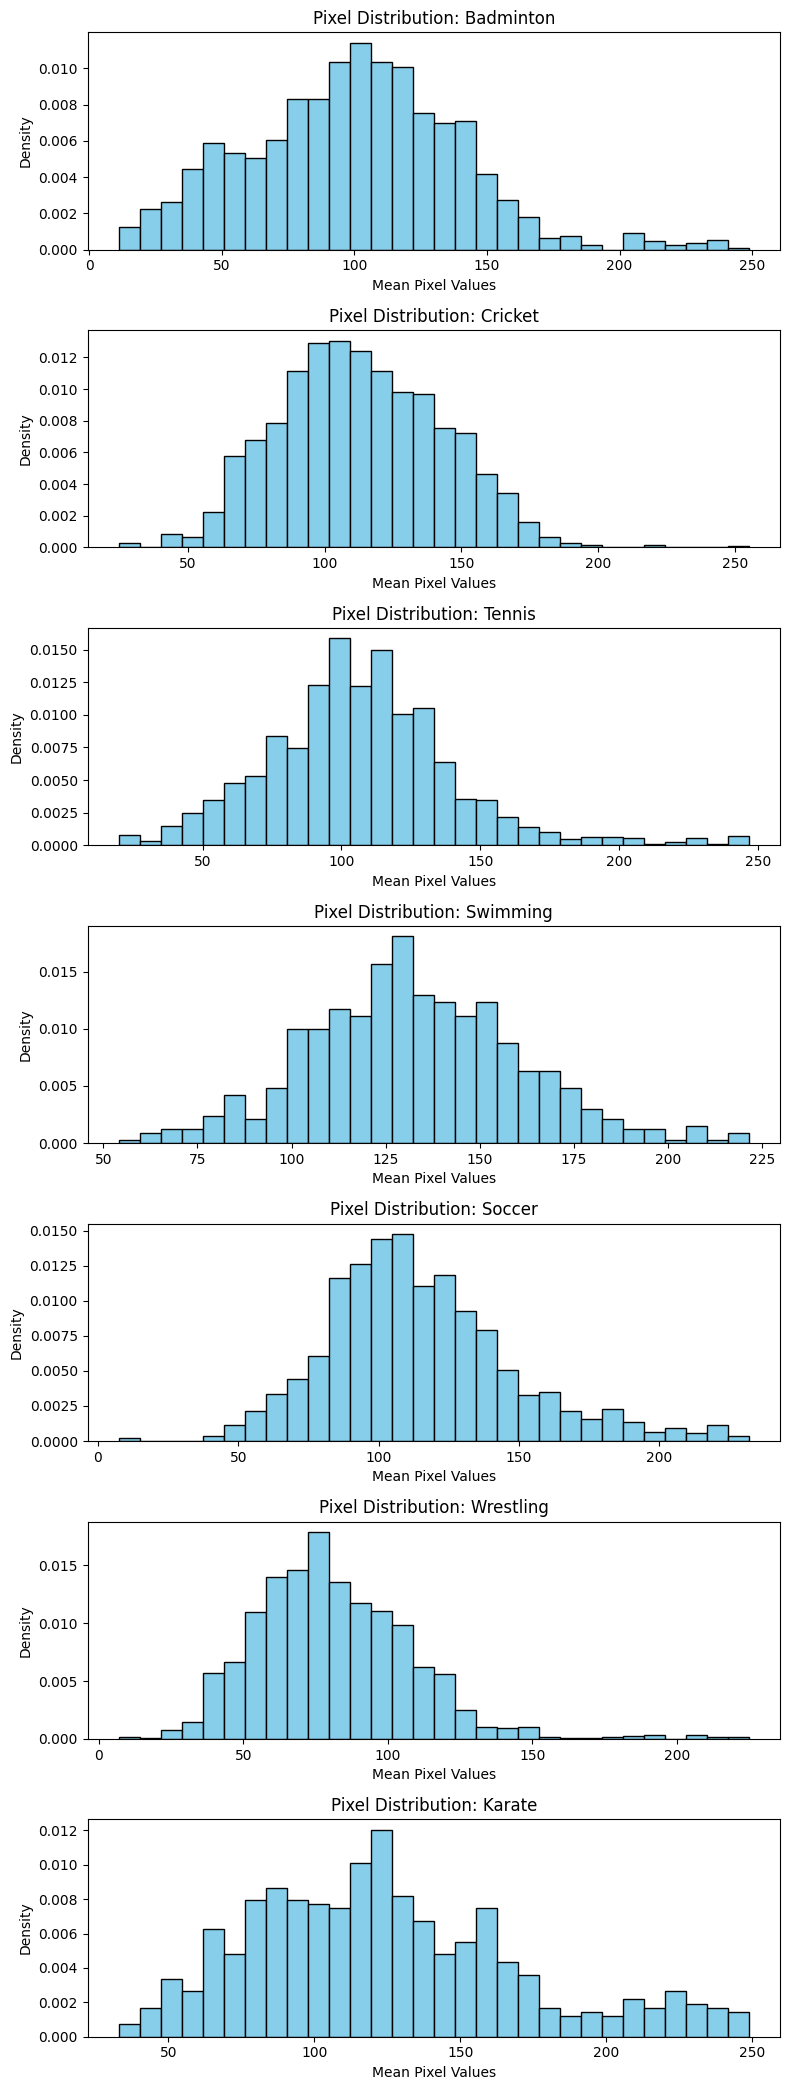

In [22]:
class_brightness = {cls: [] for cls in classes}

for cls, folder in zip(classes, train_dirs):
    if not os.path.exists(folder):
        continue
    for img_file in os.listdir(folder):
        img_path = os.path.join(folder, img_file)
        try:
            img = Image.open(img_path).convert("L")  
            img_arr = np.array(img)
            mean_brightness = img_arr.mean()
            class_brightness[cls].append(mean_brightness)
        except Exception as e:
            print(f"Failed to process {img_path}: {e}")

# Plot distributions
fig, axs = plt.subplots(len(classes), 1, figsize=(8, len(classes)*3))

for idx, cls in enumerate(tqdm(classes)):
    axs[idx].hist(class_brightness[cls], bins=30, color='skyblue', edgecolor='black', density=True)
    axs[idx].set_title(f'Pixel Distribution: {cls}')
    axs[idx].set_xlabel('Mean Pixel Values')
    axs[idx].set_ylabel('Density')

plt.tight_layout()
plt.show()

- Pixels values are distributed well across all the images meaning that the images are not too dark or too bright.
- Thus images is considered to be well exposed and not too dark or too bright so little noise are added.

## Showing some images per class

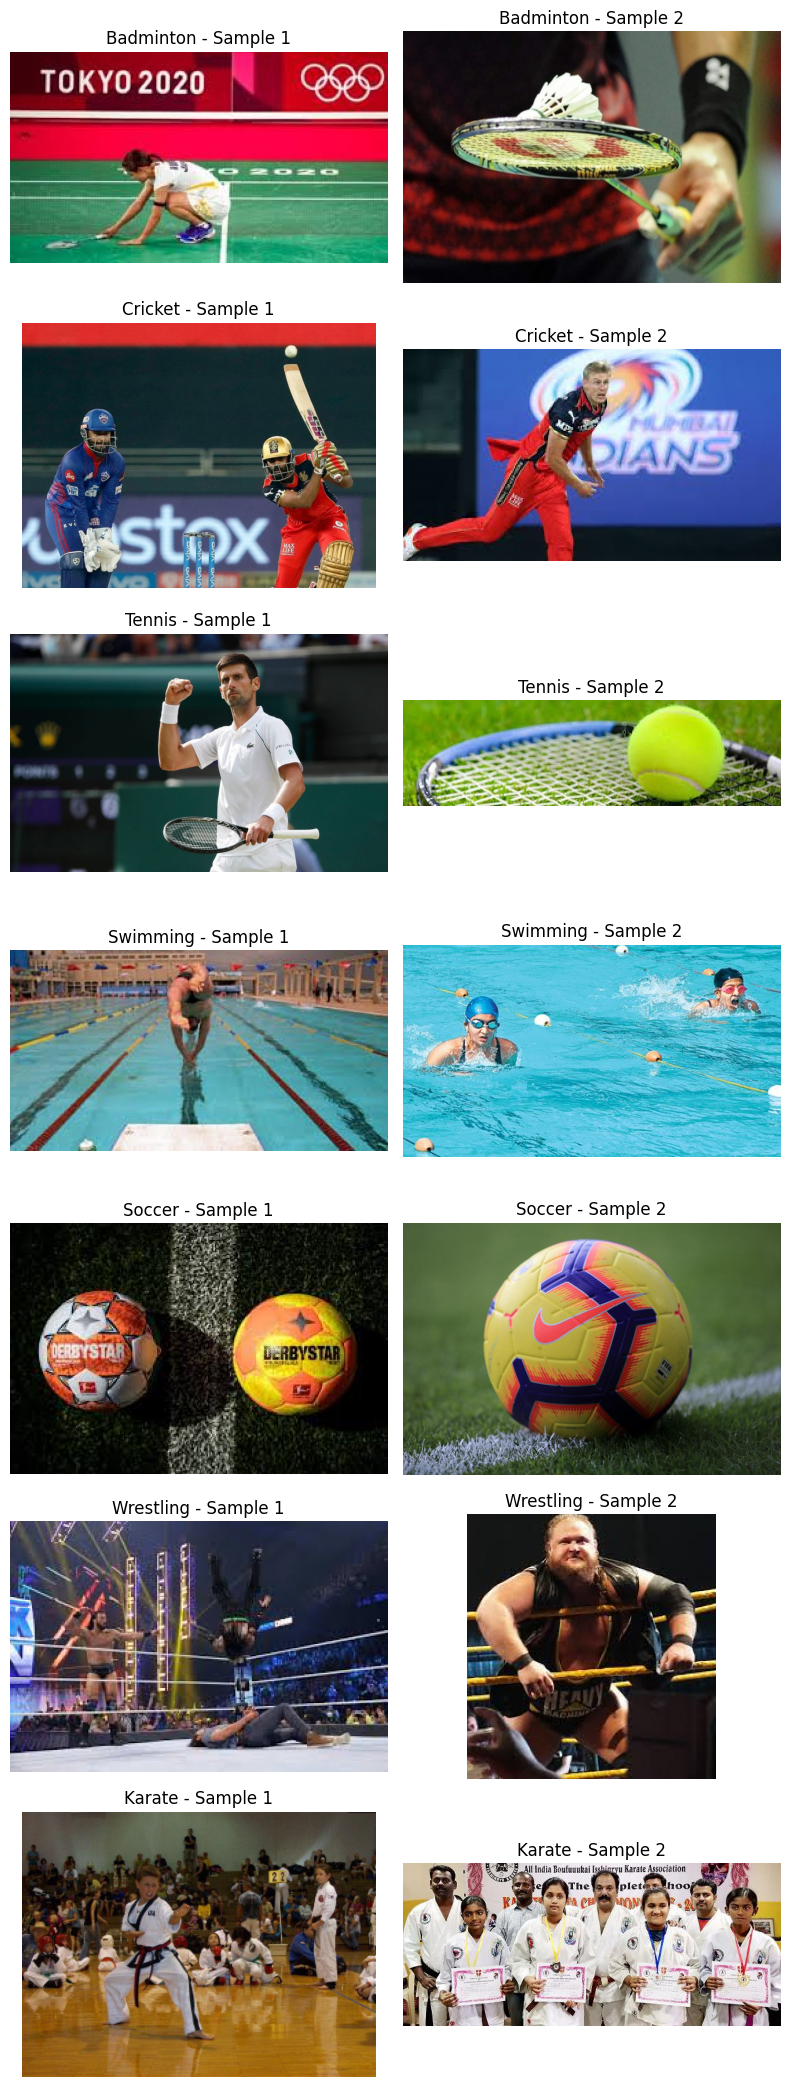

In [23]:
fig, axs = plt.subplots(len(classes), 2, figsize=(8, len(classes) * 3))

for row_idx, (cls, folder) in enumerate(zip(classes, train_dirs)):
    if not os.path.exists(folder):
        continue
    images = [f for f in os.listdir(folder) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    selected_images = images[:2]  
    for col_idx in range(2):
        if col_idx < len(selected_images):
            img_path = os.path.join(folder, selected_images[col_idx])
            img = Image.open(img_path)
            axs[row_idx, col_idx].imshow(img)
            axs[row_idx, col_idx].axis('off')
            if col_idx == 0:
                axs[row_idx, col_idx].set_title(f"{cls} - Sample 1")
            else:
                axs[row_idx, col_idx].set_title(f"{cls} - Sample 2")
        else:
            axs[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()

## Dataset class and data manager

### Dataset class

In [24]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, classes, transform=None, is_train=True):
        """
        Args:
            root_dir (str): Directory with all the class folders
            classes (list): List of class names (subfolder names)
            transform (callable, optional): Optional transform to be applied on a sample
            is_train (bool): Whether this is training data or not
        """
        self.root_dir = root_dir
        self.classes = classes
        self.transform = transform
        self.is_train = is_train
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
        self.samples = []

        # Default transforms if none provided
        if self.transform is None:
            if is_train:
                self.transform = T.Compose([
                    T.RandomResizedCrop(128), # Resize to 128x128
                    # T.RandomHorizontalFlip(),
                    # T.RandomRotation(15),
                    T.ToTensor(),
                ])
            else:
                self.transform = T.Compose([
                    T.Resize(224),
                    T.CenterCrop(128), # Resize to 128x128
                    T.ToTensor(),
                ])

        for idx, cls in enumerate(classes):
            class_folder = os.path.join(root_dir, cls)
            if not os.path.isdir(class_folder):
                continue
            for img_name in os.listdir(class_folder):
                if img_name.lower().endswith(('jpg', 'jpeg', 'png')):
                    img_path = os.path.join(class_folder, img_name)
                    self.samples.append((img_path, idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx, retry=0):
        img_path, label = self.samples[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            if retry < 3:
                return self.__getitem__(random.randint(0, len(self)-1), retry=retry+1)
            else:
                raise RuntimeError("Too many failed image loads.")


In [25]:
classes = ['Badminton', 'Cricket', 'Tennis', 'Swimming', 'Soccer', 'Wrestling', 'Karate']

In [26]:
train_dir

'../data/dataset/train/'

## Model 1: Simple CNN1

In [27]:
class Simplenet1(nn.Module):
    def __init__(self, num_classes=7):
        super(Simplenet1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), # 128 128 3 -> 128 128 64 
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # 128 128 64 -> 64 64 64
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 64 64 64 -> 64 64 128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # 64 64 128 -> 32 32 128
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # 32 32 128 -> 32 32 256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # 32 32 256 -> 16 16 256
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1), # 16 16 256 -> 16 16 512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # 16 16 512 -> 8 8 512
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), # 8 8 512 -> 1 1 512
            nn.Flatten(), # 1 1 512 -> 512
            nn.Linear(512, 256), # 512 -> 256
            nn.ReLU(inplace=True),
            nn.Dropout(0.5), # Dropout layer
            nn.Linear(256, 128), # 256 -> 128
            nn.ReLU(inplace=True),
            nn.Dropout(0.5), # Dropout layer
            nn.Linear(128, num_classes), # 128 -> num_classes
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## Model 2: Simple CNN2

In [28]:
class Simplenet2(nn.Module):
    def __init__(self, num_classes=7):
        super(Simplenet2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False), # 128x128x3 → 128x128x64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False), # 128x128x64 → 128x128x64
            nn.BatchNorm2d(64), 
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2), # 128x128x64 → 64x64x64

            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False), # 64x64x64 → 64x64x128
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False), # 64x64x128 → 64x64x128
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2), # 64x64x128 → 32x32x128

            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False), # 32x32x128 → 32x32x256
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False), # 32x32x256 → 32x32x256
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2), # 32x32x256 → 16x16x256

            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False), # 16x16x256 → 16x16x512
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False), # 16x16x512 → 16x16x512
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2), # 16x16x512 → 8x8x512

            nn.Conv2d(512, 256, kernel_size=3, padding=1, bias=False), # 8x8x512 → 8x8x256
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2) # 8x8x256 → 4x4x256
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                  # 4x4x256 = 4096
            nn.Linear(256 * 4 * 4, 512),   # 4096 → 512
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)   # 512 → num_classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## Model 3: Simple CNN3

In [ ]:
class SimpleNet3(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleNet3, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2), # 128 128 3 -> 63 63 64
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 63 63 64 -> 31 31 64
            nn.Conv2d(16, 32, kernel_size=3, stride=2),  # 31 31 64 -> 14 14 128
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), #   14 14 128 -> 7 7 128
            nn.Conv2d(32, 64, kernel_size=3, stride=2), # 7 7 128 -> 3 3 256
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(576, 288),
            nn.ReLU(inplace=True),
            nn.Linear(288, 144),
            nn.ReLU(inplace=True),
            nn.Linear(144, 72),
            nn.ReLU(inplace=True),
            nn.Linear(72, 36),
            nn.ReLU(inplace=True),
            nn.Linear(36, 18),
            nn.ReLU(inplace=True),
            nn.Linear(18, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## Model 4: Simple CNN4

In [ ]:
class SimpleNet4(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleNet4, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # 128 128 3 -> 128 128 32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),  # 128 128 32 -> 64 64 32
            nn.Conv2d(32, 64, kernel_size=3, padding=1),   # 64 64 32 -> 64 64 64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),  # 64 64 64 -> 32 32 64
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # 32 32 64 -> 16 16 128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),  # 16 16 128 -> 8 8 128
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),#   -> 4 x 4 x 256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Training the models

In [29]:
# Adding validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return val_loss / len(val_loader), 100. * correct / total


In [30]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10, patience=3):
    model.train()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
    best_val_loss = float('inf')
    patience_counter = 0

    device = next(model.parameters()).device

    total_batches = len(train_loader)
    total_steps = epochs * total_batches

    progress_bar = tqdm(total=total_steps, desc="Training", dynamic_ncols=True)
    train_epoch_vals_loss = []
    val_epoch_vals_loss = []
    train_epoch_vals_acc = []
    val_epoch_vals_acc = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Reset per-epoch storage
        train_loss_iter = []
        train_acc_iter = []

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            train_loss = running_loss / (i + 1)
            train_acc = 100. * correct / total

            train_loss_iter.append(train_loss)
            train_acc_iter.append(train_acc)

            # Update per iteration
            progress_bar.update(1)
            progress_bar.set_postfix({
                'Epoch': f'{epoch+1}/{epochs}',
                'Iter': f'{i+1}/{total_batches}',
                'Train Loss': f'{train_loss:.4f}',
                'Train Acc': f'{train_acc:.2f}%'
            })

        # Validation phase (only ONCE per epoch)
        val_loss, val_acc = validate_model(model, val_loader, criterion)

        # Update after epoch ends
        progress_bar.set_postfix({
            'Epoch': f'{epoch+1}/{epochs}',
            'Iter': f'{total_batches}/{total_batches}',
            'Train Loss': f'{sum(train_loss_iter)/len(train_loss_iter):.4f}',
            'Train Acc': f'{sum(train_acc_iter)/len(train_acc_iter):.2f}%',
            'Val Loss': f'{val_loss:.4f}',
            'Val Acc': f'{val_acc:.2f}%'
        })

        scheduler.step(val_loss)
        
        train_epoch_vals_loss.append(sum(train_loss_iter)/len(train_loss_iter))
        val_epoch_vals_loss.append(val_loss)
        train_epoch_vals_acc.append(sum(train_acc_iter)/len(train_acc_iter))
        val_epoch_vals_acc.append(val_acc)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                progress_bar.set_description("Early Stopping")
                break

    progress_bar.close()
    return train_epoch_vals_loss, val_epoch_vals_loss, train_epoch_vals_acc, val_epoch_vals_acc


In [31]:
batch_size = 64
train_dataset = ImageDataset(root_dir=train_dir, classes=classes, is_train=True)
test_dataset = ImageDataset(root_dir=test_dir, classes=classes, is_train=False)

In [32]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True if torch.cuda.is_available() else False
)


In [33]:
lr = 0.001

In [34]:
# Kaiming Normalization
def kaiming_normal_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [ ]:
model = Simplenet1(num_classes=7).to(device)
model.apply(kaiming_normal_init)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=50,patience=5)

In [ ]:
model = Simplenet2(num_classes=7).to(device)
model.apply(kaiming_normal_init)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=50,patience=5)

In [ ]:
model = Simplenet3(num_classes=7).to(device)
model.apply(kaiming_normal_init)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=50,patience=5)

In [ ]:
model = Simplenet4(num_classes=7).to(device)
model.apply(kaiming_normal_init)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=50,patience=5)

In [3]:
def freeze_all_but_last_n(model, n=2):
    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Get list of named children modules (e.g. layers)
    children = list(model.children())

    # Unfreeze last n layers
    for child in children[-n:]:
        for param in child.parameters():
            param.requires_grad = True

    return model

In [4]:
def print_trainable_params(model):
    print("Trainable Parameters:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name}: {param.shape}")

In [17]:
# Load models
resnet_variants = {
    'resnet18': models.resnet18,
    'resnet34': models.resnet34,
    'resnet50': models.resnet50,
    'resnet101': models.resnet101,
    'resnet152': models.resnet152,
}
vgg16 = models.vgg16(pretrained=True)
alexnet = models.alexnet(pretrained=True)
googlenet = models.googlenet(pretrained=True)

In [21]:
for name, constructor in resnet_variants.items():
    print(f"==================== {name} ====================")
    model = constructor(pretrained=True)
    model = freeze_all_but_last_n(model, n=2)
    print_trainable_params(model)

==================== resnet18 ====================
Trainable Parameters:
fc.weight: torch.Size([1000, 512])
fc.bias: torch.Size([1000])
==================== resnet34 ====================


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:20<00:00, 4.32MB/s]
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DE

Trainable Parameters:
fc.weight: torch.Size([1000, 512])
fc.bias: torch.Size([1000])
==================== resnet50 ====================


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:31<00:00, 3.30MB/s]
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Trainable Parameters:
fc.weight: torch.Size([1000, 2048])
fc.bias: torch.Size([1000])
==================== resnet101 ====================


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:47<00:00, 3.75MB/s] 
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Trainable Parameters:
fc.weight: torch.Size([1000, 2048])
fc.bias: torch.Size([1000])
==================== resnet152 ====================


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\resnet152-394f9c45.pth
100%|██████████| 230M/230M [01:02<00:00, 3.85MB/s] 


Trainable Parameters:
fc.weight: torch.Size([1000, 2048])
fc.bias: torch.Size([1000])


In [14]:
vgg16 = freeze_all_but_last_n(vgg16, 2)
print("==================== VGG16 ====================")
print_trainable_params(vgg16)

==================== VGG16 ====================
Trainable Parameters:
classifier.0.weight: torch.Size([4096, 25088])
classifier.0.bias: torch.Size([4096])
classifier.3.weight: torch.Size([4096, 4096])
classifier.3.bias: torch.Size([4096])
classifier.6.weight: torch.Size([1000, 4096])
classifier.6.bias: torch.Size([1000])


In [15]:
alexnet = freeze_all_but_last_n(alexnet, 2)
print("==================== ALEXNET ====================")
print_trainable_params(alexnet)

==================== ALEXNET ====================
Trainable Parameters:
classifier.1.weight: torch.Size([4096, 9216])
classifier.1.bias: torch.Size([4096])
classifier.4.weight: torch.Size([4096, 4096])
classifier.4.bias: torch.Size([4096])
classifier.6.weight: torch.Size([1000, 4096])
classifier.6.bias: torch.Size([1000])


In [16]:
googlenet = freeze_all_but_last_n(googlenet, 2)
print("==================== GOOGLENET ====================")
print_trainable_params(googlenet)


==================== GOOGLENET ====================
Trainable Parameters:
fc.weight: torch.Size([1000, 1024])
fc.bias: torch.Size([1000])
